<Center><h2>Database Translation - Airline Analysis</h2></center>

### Import libraries

In [1]:
import psycopg2
import json
import requests
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

#### Loading the JSON data 
- This code retrieves JSON data from a specified URL and writes it to a local file named "airlines.json".
- It ensures the request is successful before extracting and saving the JSON data.

In [2]:
# URL of the JSON data
url = "https://think.cs.vt.edu/corgis/datasets/json/airlines/airlines.json"
response = requests.get(url)
if response.status_code == 200:
    # Get the JSON data from the response
    json_data = response.json()

# Write the json data 
with open('airlines.json','w') as json_file:
     json_file.write(response.text)

### Create SQL connection and database

In [3]:
#establishing the connection
conn = psycopg2.connect(
   database="postgres", 
   user='postgres',
   password='password', 
   host='127.0.0.1',
   port= '5432'
)
conn.autocommit = True

#Creating a cursor object using the cursor() method to act as interface to our database
cursor = conn.cursor()

In [4]:
#Preparing query to create a database
sql = '''CREATE database mydb''';

#Creating a database
cursor.execute(sql)
print("Database created successfully........")

Database created successfully........


### Creating tables  - airports, time and statistics.
Restructuring the JSON data into three separate tables (Time, Airport, and Statistics) helps in simplifying and organizing the data, making it more suitable for analysis in SQL.

1. SQL tables are created for each identified entity, based on the attributes present in the JSON data.
   - Airport Table: This table contains columns such as Code and Name.
   - Time Table: This table includes columns such as Label, Month, Month Name, and Year.
   - Statistics Table: This table contains columns for various statistics like No of Delays, Carriers, and Flights, along with their respective attributes.

2. Relationships between the tables are established using foreign keys to determine the appropriate relationships :
   - The Statistics table has a foreign key referencing the Time table (e.g., time_label) to link each statistic entry to a specific time period.
   - Similarly, the Statistics table has a foreign key referencing the Airport table (e.g., airport_code) to associate each statistic with a specific airport.

In [5]:
airports_table="""CREATE TABLE IF NOT EXISTS airports (
    Code VARCHAR(3) PRIMARY KEY,
    Name VARCHAR(255)
);"""
# Creating the table
cursor.execute(airports_table)

In [6]:
time_table="""CREATE TABLE IF NOT EXISTS time (
    Label VARCHAR(10) PRIMARY KEY,
    Month INTEGER,
    Month_Name VARCHAR(20),
    Year INTEGER
);"""
# Creating the table
cursor.execute(time_table)

In [7]:
stats_table="""CREATE TABLE IF NOT EXISTS statistics (
   ID SERIAL PRIMARY KEY,
        Airport_Code VARCHAR(3) REFERENCES airports(Code),
        Time_Label VARCHAR(10) REFERENCES Time(Label),
        Delays_Carrier INT,
        Delays_Late_Aircraft INT,
        Delays_National_Aviation_System INT,
        Delays_Security INT,
        Delays_Weather INT,
        Carriers_Names TEXT,
        Carriers_Total INT,
        Flights_Cancelled INT,
        Flights_Delayed INT,
        Flights_Diverted INT,
        Flights_On_Time INT,
        Flights_Total INT,
        Minutes_Delayed_Carrier INT,
        Minutes_Delayed_Late_Aircraft INT,
        Minutes_Delayed_National_Aviation_System INT,
        Minutes_Delayed_Security INT,
        Minutes_Delayed_Weather INT,
        Minutes_Delayed_Total INT
);"""
# Creating the table
cursor.execute(stats_table)

### Data insertion to SQL tables
- This function inserts data into three tables: 'Airports', 'Time', and 'Statistics'.
- For each entry in the input data, it extracts relevant information and inserts it into the respective tables.
- It uses the provided cursor and connection to execute SQL queries and commit changes to the database.

In [8]:
# Function to insert data into PostgreSQL database
def insert_data(data):
    """
    Insert data into the 'Airports', 'Time', and 'Statistics' tables in the database.
    Args:
    - data (list): A list of dictionaries containing airlines data to be inserted.
    - cursor: The cursor object used to execute SQL queries.
    - conn: The connection object representing the database connection.

    Returns:
    - None
    """
    for entry in data:
        airport_data = (entry['Airport']['Code'], entry['Airport']['Name'])
        cursor.execute(""" INSERT INTO Airports (Code, Name)
        VALUES (%s, %s)
        ON CONFLICT DO NOTHING """, airport_data)
        
        time_data = (entry['Time']['Label'], entry['Time']['Month'], entry['Time']['Month Name'], entry['Time']['Year'])
        cursor.execute("""INSERT INTO Time (Label, Month, Month_Name, Year)
        VALUES (%s, %s, %s, %s)
        ON CONFLICT DO NOTHING""", time_data)

        statistics_data = ( entry['Airport']['Code'], entry['Time']['Label'],
        entry['Statistics']['# of Delays']['Carrier'], entry['Statistics']['# of Delays']['Late Aircraft'],
        entry['Statistics']['# of Delays']['National Aviation System'], entry['Statistics']['# of Delays']['Security'],
        entry['Statistics']['# of Delays']['Weather'],
        entry['Statistics']['Carriers']['Names'], entry['Statistics']['Carriers']['Total'],
        entry['Statistics']['Flights']['Cancelled'], entry['Statistics']['Flights']['Delayed'],
        entry['Statistics']['Flights']['Diverted'], entry['Statistics']['Flights']['On Time'], entry['Statistics']['Flights']['Total'],
        entry['Statistics']['Minutes Delayed']['Carrier'], entry['Statistics']['Minutes Delayed']['Late Aircraft'],
        entry['Statistics']['Minutes Delayed']['National Aviation System'], entry['Statistics']['Minutes Delayed']['Security'],
        entry['Statistics']['Minutes Delayed']['Weather'], entry['Statistics']['Minutes Delayed']['Total'] )
        
        cursor.execute("""INSERT INTO Statistics (
            Airport_Code, Time_Label,
            Delays_Carrier, Delays_Late_Aircraft, Delays_National_Aviation_System,
            Delays_Security, Delays_Weather,
            Carriers_Names, Carriers_Total,
            Flights_Cancelled, Flights_Delayed, Flights_Diverted, Flights_On_Time, Flights_Total,
            Minutes_Delayed_Carrier, Minutes_Delayed_Late_Aircraft, Minutes_Delayed_National_Aviation_System,
            Minutes_Delayed_Security, Minutes_Delayed_Weather, Minutes_Delayed_Total
        )
        VALUES ( %s, %s,%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""", statistics_data)
        conn.commit()

In [9]:
# Read the JSON files
with open('airlines.json','r') as json_file:
    data = json.load(json_file)

# Insert table function call
insert_data(data)

### Queries and Analysis

##### Table 1: Airports overview

The airport table contains details of all the Airport codes and the airport names.

In [10]:
# Records of airports and codes
table1= """SELECT * FROM airports"""
airport_df = pd.read_sql(table1,conn)
airport_df

,code,name
0,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern..."
1,BOS,"Boston, MA: Logan International"
2,BWI,"Baltimore, MD: Baltimore/Washington Internatio..."
3,CLT,"Charlotte, NC: Charlotte Douglas International"
4,DCA,"Washington, DC: Ronald Reagan Washington National"
5,DEN,"Denver, CO: Denver International"
6,DFW,"Dallas/Fort Worth, TX: Dallas/Fort Worth Inter..."
7,DTW,"Detroit, MI: Detroit Metro Wayne County"
8,EWR,"Newark, NJ: Newark Liberty International"
9,FLL,"Fort Lauderdale, FL: Fort Lauderdale-Hollywood..."


##### Table 2: Time periods overview
This table contains the time periods of the airline operations that took place, with fields Label , month, month name and year 

In [11]:
# Table containing recorded time periods of airline operations
table2 = """SELECT * FROM time"""
time_df = pd.read_sql(table2,conn)
time_df

,label,month,month_name,year
0,2003/06,6,June,2003
1,2003/07,7,July,2003
2,2003/08,8,August,2003
3,2003/09,9,September,2003
4,2003/10,10,October,2003
...,...,...,...,...
147,2015/09,9,September,2015
148,2015/10,10,October,2015
149,2015/11,11,November,2015
150,2015/12,12,December,2015


##### Table 3 : Statistics overview
This table presents various statistics related to flights, including delays, on-time operations, total flights, and diversions, etc.

In [12]:
# Statistics table with no of delays, total on time flight etc of airlines
table3 = """SELECT * FROM statistics"""
stats_df = pd.read_sql(table3,conn)
stats_df

,id,airport_code,time_label,delays_carrier,delays_late_aircraft,delays_national_aviation_system,delays_security,delays_weather,carriers_names,carriers_total,...,flights_delayed,flights_diverted,flights_on_time,flights_total,minutes_delayed_carrier,minutes_delayed_late_aircraft,minutes_delayed_national_aviation_system,minutes_delayed_security,minutes_delayed_weather,minutes_delayed_total
0,1,ATL,2003/06,1009,1275,3217,17,328,"American Airlines Inc.,JetBlue Airways,Contine...",11,...,5843,27,23974,30060,61606,68335,118831,518,19474,268764
1,2,BOS,2003/06,374,495,685,3,66,"American Airlines Inc.,Alaska Airlines Inc.,Co...",14,...,1623,3,7875,9639,20319,28189,24400,99,4160,77167
2,3,BWI,2003/06,296,477,389,8,78,"American Airlines Inc.,Continental Air Lines I...",11,...,1245,15,6998,8287,13635,26810,17556,278,6201,64480
3,4,CLT,2003/06,300,472,735,2,54,"American Airlines Inc.,Continental Air Lines I...",11,...,1562,14,7021,8670,14763,23379,23804,127,3792,65865
4,5,DCA,2003/06,283,268,487,4,58,"American Airlines Inc.,Alaska Airlines Inc.,Co...",13,...,1100,18,5321,6513,13775,13712,20999,120,4141,52747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48483,48484,SAN,2016/01,280,397,171,2,20,"American Airlines Inc.,Alaska Airlines Inc.,Je...",11,...,871,18,5030,6016,15482,23023,6021,79,1601,46206
48484,48485,SEA,2016/01,357,513,351,2,50,"American Airlines Inc.,Alaska Airlines Inc.,Je...",10,...,1274,31,8330,9739,25461,32693,11466,73,4324,74017
48485,48486,SFO,2016/01,560,947,2194,2,119,"American Airlines Inc.,Alaska Airlines Inc.,Je...",10,...,3825,20,8912,13206,43641,72557,153416,66,8930,278610
48486,48487,SLC,2016/01,338,540,253,3,38,"American Airlines Inc.,Alaska Airlines Inc.,Je...",8,...,1175,14,7426,8699,32066,33682,8057,57,3116,76978


In [13]:
stats_df.columns

Index(['id', 'airport_code', 'time_label', 'delays_carrier',
       'delays_late_aircraft', 'delays_national_aviation_system',
       'delays_security', 'delays_weather', 'carriers_names', 'carriers_total',
       'flights_cancelled', 'flights_delayed', 'flights_diverted',
       'flights_on_time', 'flights_total', 'minutes_delayed_carrier',
       'minutes_delayed_late_aircraft',
       'minutes_delayed_national_aviation_system', 'minutes_delayed_security',
       'minutes_delayed_weather', 'minutes_delayed_total'],
      dtype='object')

##### Query 1: Busiest operating aiports
This query summarizes the total number of flights for each airport, ranking them by flight volume to identify the top 10 busiest airports.

In [14]:
query1="""SELECT Airport_Code, SUM(Flights_Total) AS Total_Flights
FROM Statistics
GROUP BY Airport_Code
ORDER BY Total_Flights DESC
LIMIT 10;"""
busy_airports_df =pd.read_sql(query1,conn)
busy_airports_df

,airport_code,total_flights
0,ATL,56021251
1,ORD,46305490
2,DFW,39996209
3,LAX,30641116
4,DEN,30504144
5,IAH,26191011
6,PHX,25474086
7,LAS,21717179
8,SFO,20314921
9,DTW,18982205


##### Insights:
Hartsfield-Jackson Atlanta International Airport (ATL) is the busiest airport by a significant margin, with over 50 million total flights. The top 10 busiest airports most likely have extensive infrastructure and services to handle the high volume of flights and passengers efficiently.

##### Query 2: Trend of total no of flights operating over different years
Analyzes the trend of total flights operated each year,between the years 2004 and 2015. It provides insights into the overall growth or decline in flight operations over this period.
- The query aggregates the total number of flights operated, omitting any cancelled flights, by joining the "Statistics" and "Time" tables using the Time label as a foreign key. 
- The results are grouped by year and sorted chronologically.

In [15]:
query2= """SELECT t.year, SUM(s.flights_total - s.flights_cancelled) AS Total_Flights FROM Time t
    JOIN Statistics s ON t.Label = s.time_label
    WHERE t.year >2003 and t.year <2016
    GROUP BY t.year
    ORDER BY t.year"""
flight_trends= pd.read_sql(query2,conn)
flight_trends

,year,total_flights
0,2004,46934745
1,2005,47193674
2,2006,47954247
3,2007,48794053
4,2008,46419989
5,2009,43786149
6,2010,43733294
7,2011,42304108
8,2012,42920845
9,2013,44509773


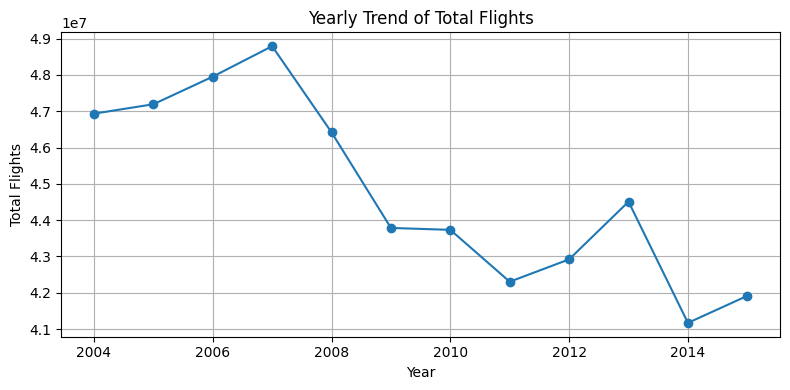

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(flight_trends['year'], flight_trends['total_flights'],marker='o',linestyle='-')

plt.title('Yearly Trend of Total Flights')
plt.xlabel('Year')
plt.ylabel('Total Flights')
plt.grid(True)
plt.tight_layout()
plt.show()

##### Insights: 
The line plot illustrates the yearly trend of total flights operated, showing a notable increase from 2004 to 2005, followed by a gradual decline until approximately 2012. Interestingly, there is a slight uptick observed between 2012 and 2013. This trend suggests a period of growth in aviation activity during the mid-2000s, followed by a decrease in subsequent years, with a potential resurgence in activity around 2013. The decline in total flights after the slight increase in 2012-2013 highlights how the aviation industry can be unpredictable and subject to change.

##### Query 3: Percentage of flights operating On Time Vs Cancelled flights
- The query gathers data on the on-time and cancelled flight percentages for each airport by calculating the sum of on-time and cancelled flights over the sum of total flights operated (aggregation of flights over all the years).
- These results are grouped for each airport code, with results sorted based on the on-time flights percentage,this allows us to identify airports with the highest on-time performance at the top of the list.

In [17]:
query3= """SELECT s.Airport_code,  (SUM(s.Flights_On_Time) * 100.0 / SUM(s.Flights_Total)) AS On_Time_Percentage, (SUM(s.Flights_Cancelled) * 100.0 /SUM(s.Flights_Total)) AS Cancelled_flights_Percentage
FROM statistics s
GROUP BY Airport_code
ORDER BY on_time_percentage DESC
"""
compare_flights_df =pd.read_sql(query3,conn)
compare_flights_df

,airport_code,on_time_percentage,cancelled_flights_percentage
0,SLC,84.249328,0.981987
1,PHX,82.423895,1.049561
2,PDX,80.759415,0.789006
3,MSP,80.342827,1.408576
4,MDW,80.317165,1.303054
5,CLT,80.310017,1.540100
6,BWI,80.268309,1.317164
7,DEN,80.236443,1.295516
8,DTW,80.182134,1.731980
9,IAH,80.117228,1.297606


In [18]:
#Columns to plot from on
airport_codes = compare_flights_df['airport_code']
on_time_percentage = compare_flights_df['on_time_percentage']
cancelled_flights_percentage = compare_flights_df['cancelled_flights_percentage']

# Create the stacked bar chart
fig = go.Figure(data=[
    go.Bar(name='On Time Percentage', x=airport_codes, y=on_time_percentage),
    go.Bar(name='Cancelled Flights Percentage', x=airport_codes, y=cancelled_flights_percentage)
])

# Update layout
fig.update_layout(barmode='group', title='On-Time Percentage vs Cancelled Flights Percentage by Airport', xaxis_title='Airport Code', yaxis_title='Percentage')

# Show the plot
fig.show()

##### Insights:
- Salt Lake City International Airport (SLC) has the highest on-time percentage among the airports listed, with over 84% of its flights arriving on time.
- The top airports in terms of on-time performance also tend to have relatively low percentages of cancelled flights, with most airports having less than 2% of flights cancelled.
- Airports with higher percentages of cancelled flights, such as LaGuardia Airport (LGA) and Newark Liberty International Airport (EWR), may need to focus on reducing cancellations to enhance passenger satisfaction and operational efficiency.

##### Query 4: Peak periods of flight operations
This query helps in analyzing the monthly trends of flight operations. By aggregating the total number of flight operations for each month, it provides insights into the busiest and least busy periods throughout the year.
- The query retrieves the total number of flight operations for each month by joining the "Statistics" table with the "Time" table using the time label.
- It calculates the sum of total flight operations for each month and groups the results by month, and the result is sorted based on the total flight operations,showing the months with the highest number of flight operations at the top.


In [19]:
query4 = """SELECT t.month, SUM(Flights_total) AS Total_Flight_operations
FROM Statistics s
JOIN Time t on t.label = s.time_label
GROUP BY t.month
ORDER BY Total_Flight_operations DESC;
"""
flights_df= pd.read_sql(query4, conn)
flights_df

,month,total_flight_operations
0,7,52302382
1,8,51989817
2,6,50471267
3,10,49764418
4,12,48863870
5,1,47999105
6,9,47698266
7,11,47379662
8,3,47029818
9,5,46618506


##### Insights:
- The data reveals a pattern in total flight operations across different months. July emerges as the busiest month, closely trailed by August and June, suggesting a peak in travel demand during summer. In contrast, February experiences the lowest flight activity, with April and May also showing comparatively subdued operations.
- This analysis is useful for identifying peak travel seasons and sheds light on the seasonal fluctuations in flight activities that could be helpful to optimize airline schedules and resource management.


##### Query 5: Most common reasons for flight delays
- Flight delays attributed to five distinct reasons are recorded in the Statistics table as individual fields. These reasons were initially embedded within a nested object in the JSON dataset.
- The first query, total_delays, calculates the total number of delays by summing up delays across different categories such as Carrier, Late Aircraft, National Aviation System, Security, and Weather. This sum represents the overall delays in the dataset.
- The second query, query5, computes the percentage of total delays attributed to each delay reason. 
- This is done by dividing the sum of delays for each reason by the total number of delays obtained from the first query. 
- In this case, each SELECT query retrieves the total delays for a specific reason. By using UNION ALL, the results from each SELECT query are concatenated together, allowing us to calculate the overall percentage of delays for each reason. The query then groups the results by delay reason specified and orders them in descending order based on the percentage of total delays.

In [20]:
total_delays="""
   SELECT SUM(Delays_Carrier + Delays_Late_Aircraft + Delays_National_Aviation_System + Delays_Security + Delays_Weather) AS Total_Delays
FROM Statistics;
"""
cursor.execute(total_delays)
total_num_delays= cursor.fetchall()[0][0]

query5="""
SELECT 
    Delay_Reason,
    ROUND(SUM(Total_Delays) * 100.0 / %s, 2) AS Percentage_Total_Delays
FROM 
    (   SELECT 'Carrier' AS Delay_Reason, Delays_Carrier AS Total_Delays FROM Statistics
        UNION ALL
        SELECT 'Late Aircraft' AS Delay_Reason, Delays_Late_Aircraft AS Total_Delays FROM Statistics
        UNION ALL
        SELECT 'National Aviation System' AS Delay_Reason, Delays_National_Aviation_System AS Total_Delays FROM Statistics
        UNION ALL
        SELECT 'Security' AS Delay_Reason, Delays_Security AS Total_Delays FROM Statistics
        UNION ALL
        SELECT 'Weather' AS Delay_Reason, Delays_Weather AS Total_Delays FROM Statistics
    ) AS subquery
GROUP BY 
    Delay_Reason
ORDER BY 
    Percentage_Total_Delays DESC;
"""
delay_percent_df=pd.read_sql(query5,(conn),params=[total_num_delays])
delay_percent_df

,delay_reason,percentage_total_delays
0,National Aviation System,39.74
1,Late Aircraft,32.85
2,Carrier,23.92
3,Weather,3.26
4,Security,0.23


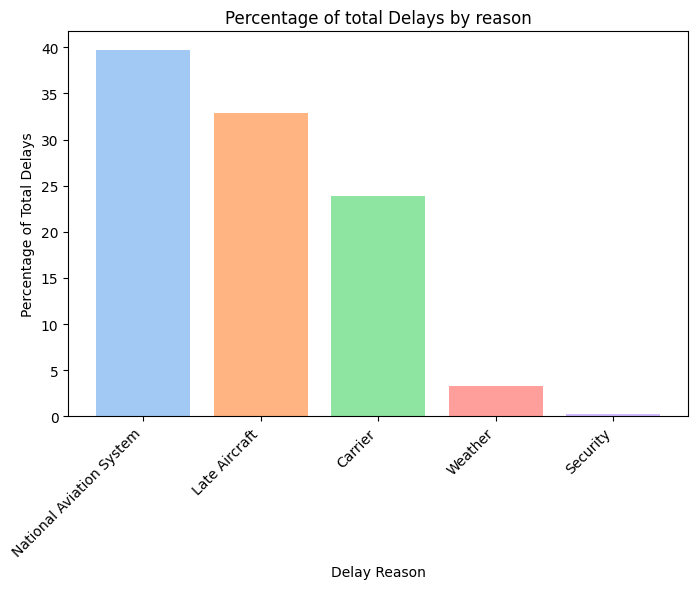

In [21]:
palette = sns.color_palette("pastel")
plt.figure(figsize=(8, 5))
plt.bar(delay_percent_df["delay_reason"],delay_percent_df["percentage_total_delays"],color=palette)
plt.title('Percentage of total Delays by reason')
plt.xlabel('Delay Reason')
plt.ylabel('Percentage of Total Delays')
plt.xticks(rotation=45, ha='right')
plt.show()

##### Analysis:
The analysis reveals that issues with the National Aviation System and late aircraft arrivals are the primary contributors to flight delays, followed by delays attributed to the carrier itself. Weather-related delays and security-related issues have a comparatively smaller impact on overall flight delays. 

##### Query 6: Airports with highest total delays by time (in minutes) including all delay factors
- The total minutes of delay experienced by each airport is determined by taking the summation of delay minutes attributed to various factors like carrier, late aircraft, national aviation system, security, and weather. 
- By grouping the results by airport code and ordering them from highest to lowest delay minutes, the query enables the identification of airports experiencing the most significant delays.

In [22]:
query6 = """SELECT Airport_Code, SUM(Delays_Carrier + Delays_Late_Aircraft + Delays_National_Aviation_System + Delays_Security + Delays_Weather) AS Total_Delayed_Minutes
FROM Statistics
GROUP BY Airport_Code
ORDER BY Total_Delayed_Minutes DESC;"""
time_delays_df=pd.read_sql(query6,conn)
time_delays_df

,airport_code,total_delayed_minutes
0,ATL,11576917
1,ORD,10834626
2,DFW,7233897
3,LAX,5887893
4,DEN,5568618
5,EWR,5352600
6,SFO,5186016
7,IAH,4758743
8,LAS,4190021
9,PHX,4177789


Text(0, 0.5, 'Total Flight delays')

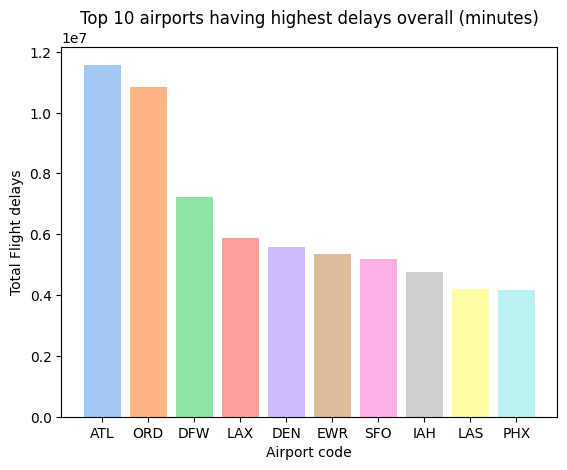

In [23]:
# Bar plot showing Top 10 airports having highest overall delays
time_delays_df=time_delays_df[:10]
palette = sns.color_palette("pastel")
plt.bar(time_delays_df["airport_code"],time_delays_df["total_delayed_minutes"],color=palette)
plt.title('Top 10 airports having highest delays overall (minutes)')
plt.xlabel('Airport code')
plt.ylabel('Total Flight delays')

##### Insights:
Airports like ATL (Hartsfield-Jackson Atlanta International), ORD (Chicago O'Hare International), and DFW (Dallas/Fort Worth International) have the highest total delayed minutes, suggesting they may face significant challenges in managing flight delays. Conversely, airports like PDX (Portland International) have relatively lower total delayed minutes, indicating better efficiency in managing flight schedules and minimizing delays. 

##### Query 7: Percentage variation on delays between Airports with highest and lowest no of delayed flight trend over the years
- Based on the results obtained in Query 6, we see that ATL has the highest delays, while PDX the least. The following query, aims to compare the percentage variation in flight delays between these two airports over the years.
- The query filters out to include only ATL and PDX flights, calculates delay percentages for each airport-year combination in a pivot table format with years as rows and airport codes as columns.

In [24]:
query7="""SELECT a.code as Airport_code,t.Year,(SUM(s.Flights_Delayed)*1.0 / SUM(s.Flights_Total) * 100) AS Delayed_Flights_Percentage
FROM time t
JOIN statistics s ON t.Label = s.Time_Label
JOIN airports a ON s.Airport_Code = a.Code
WHERE s.Airport_Code IN ('ATL', 'PDX')
GROUP BY t.year,a.code
ORDER BY t.Year ;
"""
result_df = pd.read_sql(query7,conn)
pivot_df = result_df.pivot(index='year', columns='airport_code', values='delayed_flights_percentage')
pivot_df

airport_code,ATL,PDX
year,,
2003,19.514149,15.233061
2004,24.902815,18.550886
2005,24.511633,21.323184
2006,26.103120,21.839996
2007,23.425883,22.908210
2008,22.605851,20.996232
2009,25.629043,16.384883
2010,18.787205,15.568397
2011,17.605095,16.377711


In [25]:
#Line plot showing the percentage variation on delays 
traces = []
for airport_code in pivot_df.columns:
    traces.append(go.Scatter(x=pivot_df.index, y=pivot_df[airport_code], mode='lines+markers', name=airport_code))
# Create layout
layout = go.Layout(title='Percentage of Delayed Flights Over Time',
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Percentage of Delayed Flights'))
fig = go.Figure(data=traces, layout=layout)
fig.show()

##### Analysis:
- Both airports exhibit fluctuations in delayed flight percentages over the years, with varying degrees of consistency.ATL generally experiences higher percentages of delayed flights compared to PDX.
- This variability could be influenced by factors like changes in airline schedules, airport improvements, or external events impacting air travel.
- By 2016, both ATL and PDX show a reduction in delayed flight percentages, with ATL experiencing a more substantial decrease compared to PDX. This convergence towards similar delay percentages by 2016 suggests potential improvements in on-time performance at ATL and ongoing efficiency in managing flight operations at PDX.

##### Query 8: Distribution of carriers for each airport
- The distribution of carriers for each airport is retrieved by calculating the average, maximum, and minimum total number of carriers from the Statistics table.
- These results are grouped based on the Airport code, to understand the variability of carrier distribution across different airports.

In [26]:
query8="""SELECT Airport_Code,
    AVG(Carriers_Total) AS Avg_Carriers_Total,
    MAX(Carriers_Total) AS Max_Carriers_Total,
    MIN(Carriers_Total) AS Min_Carriers_Total
    FROM statistics
    GROUP BY Airport_Code
    ORDER BY Airport_Code;
"""
result = pd.read_sql(query8,conn)
result

,airport_code,avg_carriers_total,max_carriers_total,min_carriers_total
0,ATL,13.000000,16,9
1,BOS,13.282895,17,10
2,BWI,12.000000,15,8
3,CLT,11.526316,15,8
4,DCA,13.269737,15,10
5,DEN,13.572368,17,9
6,DFW,13.328947,16,9
7,DTW,13.486842,16,10
8,EWR,12.236842,15,8
9,FLL,10.842105,13,8


##### Insights:
- Airports like LAS and LAX have a higher average number of carriers - 14 and 14.08, respectively, others like MDW and MIA have notably lower averages - 7.19 and 9.77 respectively.
- Despite variations in average carrier numbers, many airports tend to have a consistent maximum number of carriers. For instance, airports like LAS, LAX, and SAN have consistently high maximum carrier counts.
- These results suggest that airports with higher average carrier counts may offer passengers more options and potentially foster greater competition among airlines. Conversely, airports with lower carrier counts may face challenges in offering diverse flight options and competitive pricing.


##### Query 9: No of carriers serving each airports
This query retrieves the number of distinct carriers and their corresponding lists for each airport.
- The carrier names (of airlines) are provided as a column with comma-separated values. Hence, the UNNEST function is used to split the comma-separated Carriers_Names field into individual carriers and then aggregates them based on the airport code. This allows for counting the unique carriers and concatenating their names into a comma-separated list. 
- The results are ordered by the number of carriers in descending order.

In [27]:
query9="""SELECT s.Airport_Code,
COUNT(DISTINCT carrier) AS Num_Carriers,
STRING_AGG(DISTINCT carrier, ',') AS Carrier_List
FROM  statistics AS s,
    UNNEST(STRING_TO_ARRAY(s.Carriers_Names, ',')) AS carrier
GROUP BY  s.Airport_Code
ORDER BY  Num_Carriers DESC;
"""
carriers_df=pd.read_sql(query9,conn)
carriers_df

,airport_code,num_carriers,carrier_list
0,PHL,25,"AirTran Airways Corporation,Alaska Airlines In..."
1,BOS,25,"AirTran Airways Corporation,Alaska Airlines In..."
2,LGA,24,"AirTran Airways Corporation,American Airlines ..."
3,LAS,24,"AirTran Airways Corporation,Alaska Airlines In..."
4,DCA,24,"AirTran Airways Corporation,Alaska Airlines In..."
5,ATL,24,"AirTran Airways Corporation,Alaska Airlines In..."
6,BWI,24,"AirTran Airways Corporation,Alaska Airlines In..."
7,DTW,24,"AirTran Airways Corporation,Alaska Airlines In..."
8,EWR,24,"AirTran Airways Corporation,Alaska Airlines In..."
9,ORD,24,"Alaska Airlines Inc.,America West Airlines Inc..."


##### Insights:
Airports like PHL and BOS have the highest number of carriers, each with 25 distinct carriers. On the other hand, MDW and PDX have the fewest carriers, each with only 18 distinct carriers. The carrier lists show the variety of airlines operating at each airport, highlighting the diversity in airline choices available to passengers.

##### Query 10: Number of airports associated with each airlines
Here, we would like to understand how many airports do each of the airlines extend their network and breadth of their operations.
- The query retrieves the number of airports served by each carrier.It first splits the carriers' names stored as a string into individual carriers and associates them with the respective airport codes in the inner query.
- The outer query takes the result from the subquery and groups it by the carrier column and counts the number of distinct airport codes associated with each carrier using the COUNT function.
- Finally, the results are ordered based on the number of airports served by each carrier in descending order, revealing the airlines with the broadest coverage.

In [28]:
query10="""SELECT carrier,COUNT(DISTINCT Airport_Code) AS num_airports
FROM 
    (SELECT DISTINCT UNNEST(STRING_TO_ARRAY(Carriers_Names, ',')) AS carrier, 
    Airport_Code FROM statistics) AS carriers_airports
GROUP BY carrier
ORDER BY num_airports DESC;  """
airlines_df=pd.read_sql(query10,conn)
airlines_df

,carrier,num_airports
0,Delta Air Lines Inc.,29
1,American Airlines Inc.,29
2,United Air Lines Inc.,29
3,Atlantic Southeast Airlines,29
4,Continental Air Lines Inc.,29
5,Northwest Airlines Inc.,29
6,ExpressJet Airlines Inc.,29
7,SkyWest Airlines Inc.,28
8,US Airways Inc.,28
9,American Eagle Airlines Inc.,27


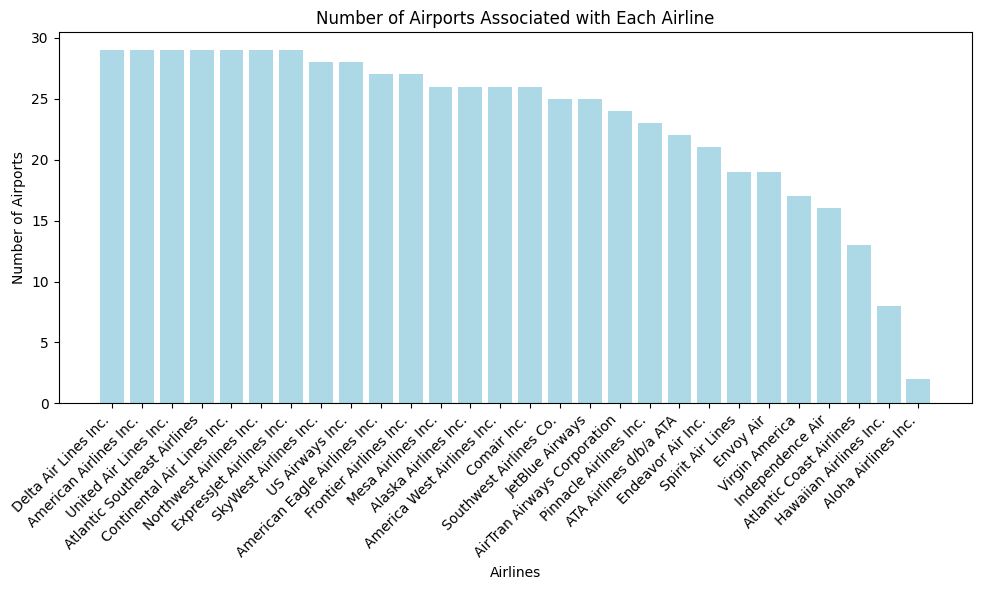

In [30]:
# Bar plot showing no of airports associated with each airline
plt.figure(figsize=(10, 6))
plt.bar(airlines_df['carrier'], airlines_df['num_airports'],color="lightblue")
plt.xlabel('Airlines')
plt.ylabel('Number of Airports')
plt.title('Number of Airports Associated with Each Airline')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### Insights:
- Delta Air Lines Inc., American Airlines Inc., United Air Lines Inc., Atlantic Southeast Airlines, Continental Air Lines Inc., and Northwest Airlines Inc. are the top 6 carriers serving the highest number of airports, each serving 29 airports.
- Hawaiian Airlines Inc. and Aloha Airlines Inc. serve the fewest airports, with 8 and 2 respectively.
The competitive landscape of the airline industry can be inferred from the distribution of airports served by different carriers. Some airlines may prioritize serving a wide range of destinations, while others may focus on specific regions or routes.